# How is resolution computed

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ctaplot.ana import resolution

## Normal distribution
For a nomal distribution, $\sigma$ corresponds to the 68 percentile of the distribution   
See the [68–95–99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule)

68th percentile = 3.0003
95th percentile = 5.9952
99th percentile = 8.9978


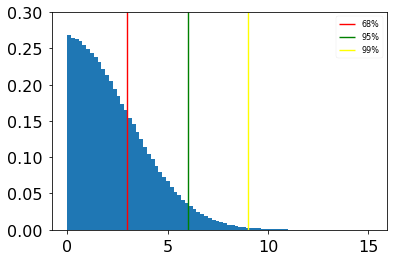

In [2]:
loc = 10
scale = 3

X = np.random.normal(size=1000000, scale=scale, loc=loc)
plt.hist(np.abs(X - loc), bins=80, density=True)

sig_68 = np.percentile(np.abs(X - loc), 68.27)
sig_95 = np.percentile(np.abs(X - loc), 95.45)
sig_99 = np.percentile(np.abs(X - loc), 99.73)

plt.vlines(sig_68, 0, 0.3, label='68%', color='red')
plt.vlines(sig_95, 0, 0.3, label='95%', color='green')
plt.vlines(sig_99, 0, 0.3, label='99%', color='yellow')
plt.ylim(0,0.3)
plt.legend()


print("68th percentile = {:.4f}".format(sig_68))
print("95th percentile = {:.4f}".format(sig_95))
print("99th percentile = {:.4f}".format(sig_99))

assert np.isclose(sig_68, scale, rtol=1e-2)
assert np.isclose(sig_95, 2 * scale, rtol=1e-2)
assert np.isclose(sig_99, 3 * scale, rtol=1e-2)

## Resolution
The resolution is defined as the 68th percentile of the relative error `err = (reco - simu)/reco`    
Hence, if the relative error follows a normal distribution, the resolution is equal to the sigma of the distribution

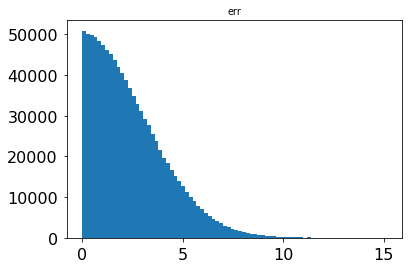

In [3]:
err = np.abs(X - loc)
simu = loc * np.ones(X.shape[0])
plt.hist(err, bins=80)
plt.title('err')
plt.show()

Let's define `reco` in order to have a relative error equals to `err`.   
Its resolution is equals to the sigma of the distribution

In [4]:
reco = simu / (1 - (X - loc))
res = resolution(simu, reco)
print(res)
assert np.isclose(res[0], scale, rtol=1e-2)

[3.00031491 2.99536414 3.00523324]


---
## Error bars

By default, the error bars are given by the [confidence interval](https://en.wikipedia.org/wiki/Confidence_interval ) at 95% (2 sigmas for a normal distribution)    
This means that we can be confident at 95% that the resolution values are within the range given by the error bars.

The implementation for percentile confidence interval follows:
- http://people.stat.sfu.ca/~cschwarz/Stat-650/Notes/PDF/ChapterPercentiles.pdf    

In [5]:
from ctaplot.ana import percentile_confidence_interval

3.0003149121993564


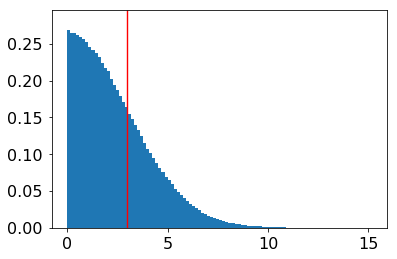

In [6]:
nbins, bins, patches = plt.hist(err, bins=100, density=True);
ymax = 1.1 * nbins.max()
# plt.vlines(X.mean(), 0, ymax)
plt.vlines(np.percentile(err, 68.27), 0, ymax, color='red')
# plt.vlines(X.mean() - X.std(), 0, ymax, color='red')
plt.ylim(0, ymax)
print(np.percentile(err, 68.27))

Now, if we take many random samples in this ditribution and measure the 68th percentile, we'll have a distribution with a measurement error.

Standard deviation = 0.042


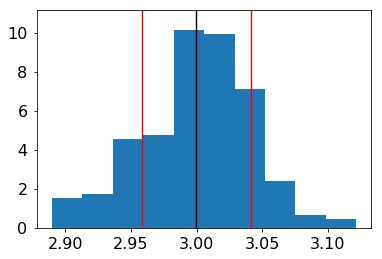

In [7]:
n = 5000
all_68 = []
for i in range(int(len(err)/n)):
    all_68.append(np.percentile(err[i*n:(i+1)*n], 68.27))
    
all_68 = np.array(all_68)
nbins, bins, patches = plt.hist(all_68, density=True);
ymax = 1.1 * nbins.max()
plt.vlines(all_68.mean(), 0, ymax)
plt.vlines(all_68.mean() + all_68.std(), 0, ymax, color='red')
plt.vlines(all_68.mean() - all_68.std(), 0, ymax, color='red')
plt.ylim(0, ymax)

print("Standard deviation = {:.3f}".format(all_68.std()))

This error can be evaluated directly through the formulae:    
    $$ R_{low} = n*p − z * \sqrt{n * p * (1 − p)} $$
    $$ R_{up} = n*p + z * \sqrt{n * p * (1 − p)} $$
    
with $p$ the percentile and $z$ the confidence level desired.

And the confidence interval given by: $X[R_{low}] : X[R_{up}]$

The confidence level is given by the cumulative distribution function (`scipy.stats.norm.cdf`). Some useful values:   
- z = 0.47 for a confidence level of 68%
- z = 1.645 for a confidence level of 95%
- z = 2.33 for a confidence level of 99%

In [8]:
p = 0.6827
z = 1.645
rl = int(n * p - z * np.sqrt(n * p * (1-p)))
ru = int(n * p + z * np.sqrt(n * p * (1-p)))
np.sort(err[:n])[rl], np.sort(err[:n])[ru], np.percentile(err[:n], 68)

(2.876986066068385, 3.010249746801188, 2.9211808551564644)

Because we are dealing with normal distributions here, we can verify that this corresponds (within statistical margins) to the interval given by twice the standard deviations:

In [11]:
err_err68 = np.abs(all_68 - all_68.mean())
all_68.mean() - 2 * err_err68.std(), all_68.mean() + 2 * err_err68.std()

(2.949511097001859, 3.0499854741178254)

In ctaplot, this is computed by the function `percentile_confidence interval`:

R68: 2.948
Interval with a confidence of 99%: (2.851, 3.038)


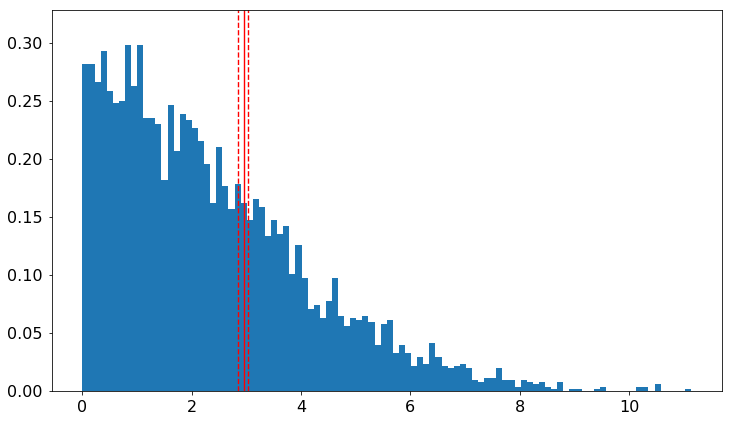

In [10]:
p = 68.27
pci = percentile_confidence_interval(err[:n], percentile=p, conf=2.33)
print("R68: {:.3f}".format(np.percentile(err[:n], p)))
print("Interval with a confidence of 99%: ({:.3f}, {:.3f})".format(pci[0], pci[1]))


plt.figure(figsize=(12,7))
nbins, bins, patches = plt.hist(err[:n], bins=100, density=True);
ymax = 1.1 * nbins.max()

plt.vlines(np.percentile(err[:n], p), 0, ymax, color='red')
plt.vlines(pci[0], 0, ymax, linestyles='--', color='red')
plt.vlines(pci[1], 0, ymax, linestyles='--', color='red',)
plt.ylim(0, ymax);